In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data()

In [ ]:
len(X_train)

60000

In [ ]:
len(X_test)

10000

In [ ]:
X_train[0].shape

(28, 28)

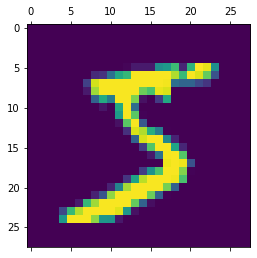

In [ ]:
plt.matshow(X_train[0])

In [ ]:
y_train[0]

5

In [ ]:
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
X_train_flattened = X_train.reshape(len(X_train), 28*28)
X_test_flattened = X_test.reshape(len(X_test), 28*28)

In [ ]:
X_train_flattened.shape

(60000, 784)

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=5)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2731 - accuracy: 0.9219
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1211 - accuracy: 0.9641
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0832 - accuracy: 0.9759
Epoch 4/5
1

In [ ]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0810 - accuracy: 0.9756


[0.08099661767482758, 0.975600004196167]

In [ ]:
model.save("./saved_model/")

INFO:tensorflow:Assets written to: ./saved_model/assets


# Post Training Quantization

**Without Quantization**

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
tflite_model = converter.convert()

**With Quantization**

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [ ]:
len(tflite_model)

319776

In [ ]:
len(tflite_quant_model)

84720

**You can see above that quantizated model is 1/4th the size of a non quantized model**

In [ ]:
!pip install --user --upgrade tensorflow-model-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!git clone https://github.com/google/qkeras.git 
import sys 
sys.path.append('qkeras') 
!pip install git+https://github.com/keras-team/keras-tuner.git 
!pip install tensorflow_model_optimization 
#import tensorflow_model_optimization as tfmot

fatal: destination path 'qkeras' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/keras-team/keras-tuner.git to /tmp/pip-req-build-13kaknw3
  Running command git clone -q https://github.com/keras-team/keras-tuner.git /tmp/pip-req-build-13kaknw3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_model_optimization as tfmot

In [ ]:
#import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 28, 28)           3         
 er)                                                             
                                                                 
 quant_flatten (QuantizeWrap  (None, 784)              1         
 perV2)                                                          
                                                                 
 quant_dense (QuantizeWrappe  (None, 100)              78505     
 rV2)                                                            
                                                                 
 quant_dense_1 (QuantizeWrap  (None, 10)               1015      
 perV2)                                                          
                                                                 
Total params: 79,524
Trainable params: 79,510
Non-traina

In [ ]:
q_aware_model.fit(X_train, y_train, epochs=1)

1875/1875 [==============================] - 8s 4ms/step - loss: 0.0442 - accuracy: 0.9864


In [ ]:
q_aware_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0741 - accuracy: 0.9784


[0.07414991408586502, 0.9783999919891357]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_qaware_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpntddzc0k/assets


INFO:tensorflow:Assets written to: /tmp/tmpntddzc0k/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
len(tflite_qaware_model)

82456

In [ ]:
with open("tflite_qaware_model.tflite", 'wb') as f:
    f.write(tflite_qaware_model)